In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wf
from glob import glob
from collections import deque
from zplane import *

#import audiofile

# 0. Plot functions

In [53]:
def simple_plot(samples, x_values= np.array([]), plt_title= "", x_label="", y_label="", display_plot=True, save_name=None, bars : list = []):
    _ = plt.figure()
    plt.title(plt_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if len(x_values) == 0:
        plt.plot(samples)
    else:
        plt.plot(x_values, samples)
    if bars != []:
        for bar in bars:
            # bar = 1
            plt.axvline(bar, color="g", linestyle="--")
            pass
    if save_name != None:
        plt.savefig(save_name)
    if display_plot:
        plt.show()
    plt.close() 

In [ ]:
def plot_create_sin(f, A, fs, N, bars : list = []):
    t, samples = create_sine_wave(f, A, fs, N, bars)
    plot_sin(t, samples)

def plot_sin(t, samples, bars : list = []):
    if type(t) == type(None):
        t = np.array([])
    simple_plot(samples, t, f"Sin wave", "Time (s)", "Amplitude (V)", display_plot=True, bars=bars)

# 1. Offline System

## 1.1 Data generation and dataset

### 1.1.1 Sine wave function

In [55]:
def create_sine_wave(f, A, fs, N):
    sampling = np.arange(0, N/fs,1/fs)
    sin_samples =  np.sin(2 * np.pi * sampling * f)
    return sampling, A * sin_samples

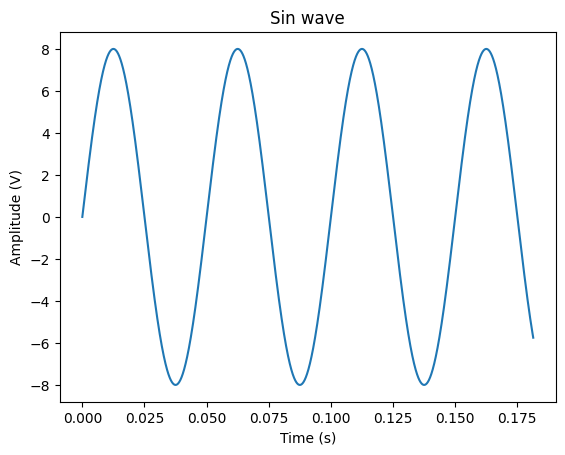

In [56]:
fs = 44.1 * 1000
N = 8000

f = 20
amplitude = 8


plot_create_sin(f, amplitude, fs, N)

### 1.1.2 Read Wavefile function

In [57]:
def read_wavefile(path):
    return wf.read(path)

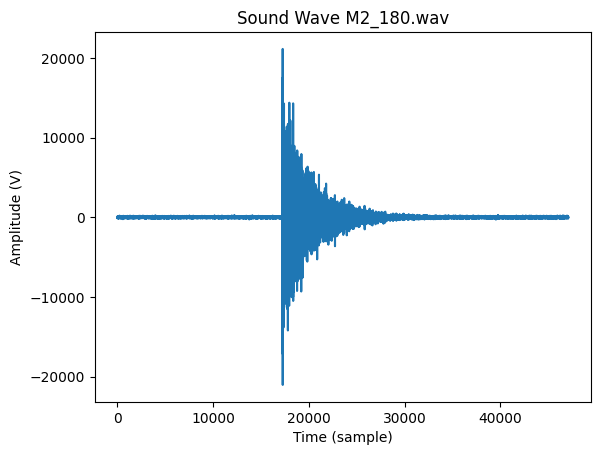

In [58]:
file_dir = "LocateClaps/"
file_name = "M2_180.wav"

t, data = read_wavefile(file_dir + file_name)

simple_plot(data, plt_title=f"Sound Wave {file_name}", x_label="Time (sample)", y_label="Amplitude (V)")

Find all files ending in `.wav`, and save the results inside a folder

In [59]:
skip_saving = True
SavePlotFile = "SoundWavePlots/"
LocateClaps = "./LocateClaps"
files = glob(f"{LocateClaps}/*.wav")

if not skip_saving:
    for file in files:
        _, data = read_wavefile(file)
        file_name = file.removeprefix(LocateClaps + "/").removesuffix(".wav") # keep only the name

        simple_plot(data, plt_title=f"Sound Wave {file_name}.wav", x_label="Time (s)", y_label="Amplitude (V)", 
                    display_plot=False, save_name=f"{SavePlotFile}/{file_name}")

## 1.2 Buffering

### 1.2.1 Create the `create_ringbuffer` function

See the following documentation : [Collections `deque`](https://docs.python.org/3/library/collections.html#collections.deque)

In [60]:
def create_ringbuffer(maxlen):
    return deque(maxlen=maxlen)

def plot_buffer_content(buffer: deque, sample_added: int, recording_time: int):
    sample_text = "sample" if sample_added == 0 else "samples"

    simple_plot(buffer, plt_title=f"Buffer contents after adding {sample_added} {sample_text} (i.e. after {recording_time} s)", 
                x_label= "Stored sample",y_label="Amplitude (s)")


### 1.2.2 Display the buffers content after *recording* for **0.1 s** and **0.15 s**

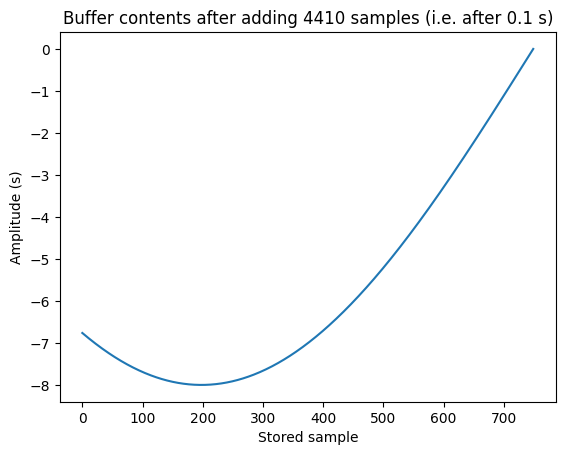

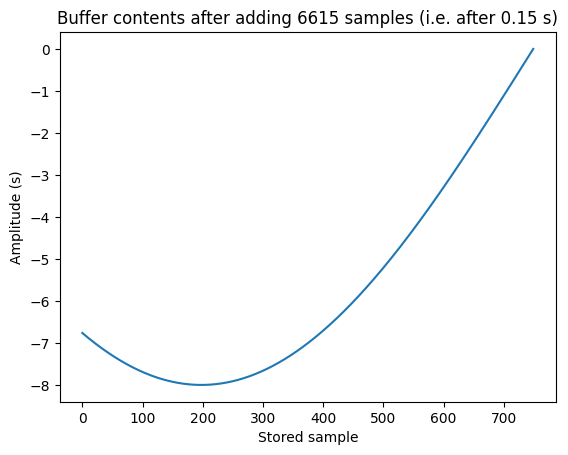

In [61]:
maxlen = 750
buffer = create_ringbuffer(maxlen)

display_at_times = [0.1, 0.15]

t, samples = create_sine_wave(f, amplitude, fs, N)
for i, samples in enumerate(samples):
    buffer.append(samples)
    for time in display_at_times:
        if i == int(time * fs):
            plot_buffer_content(buffer, i, time)
# When using our signal wave from 1.1.1, and looking at the times 0.1 & 0.01, we notice the exact same waveform.

Vérifions si cela est correcte:

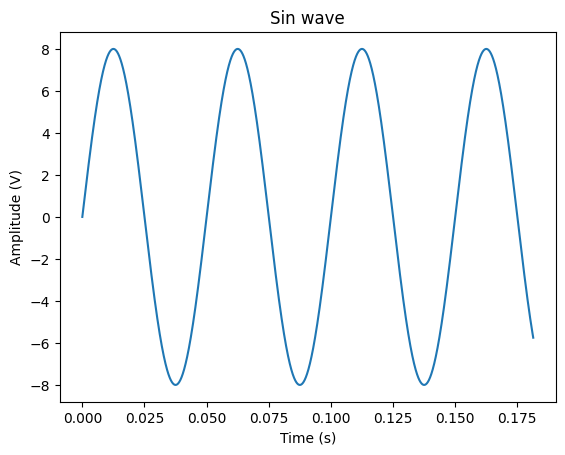

In [ ]:
fs = 44.1 * 1000
N = 8000

f = 20
amplitude = 8


plot_create_sin(f, amplitude, fs, N)

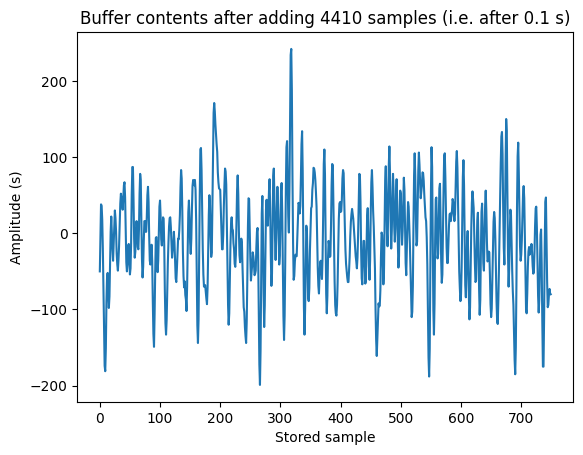

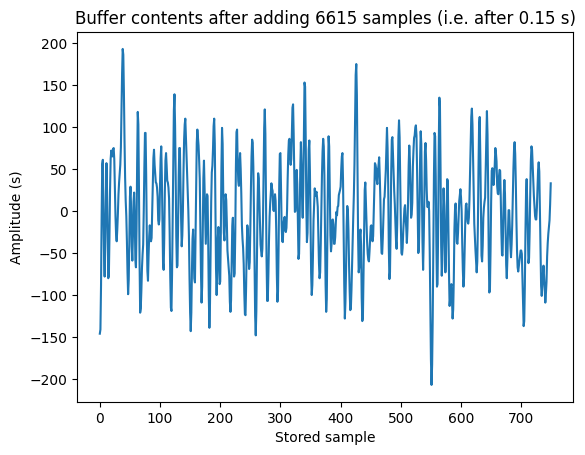

In [19]:

buffer = create_ringbuffer(maxlen)
_, data = read_wavefile("LocateClaps/M2_180.wav")

display_at_times = [0.1, 0.15]

for i, samples in enumerate(data):
    buffer.append(samples)
    for time in display_at_times:
        if i == int(time * fs):
            plot_buffer_content(buffer, i, time)

## 1.3 Pre-processing

#### 1.3.1 Normalisation

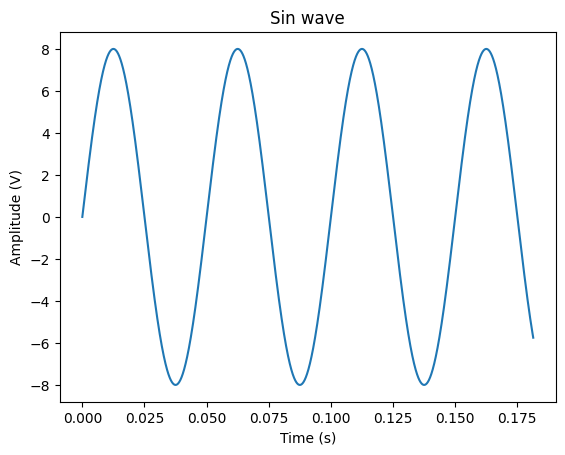

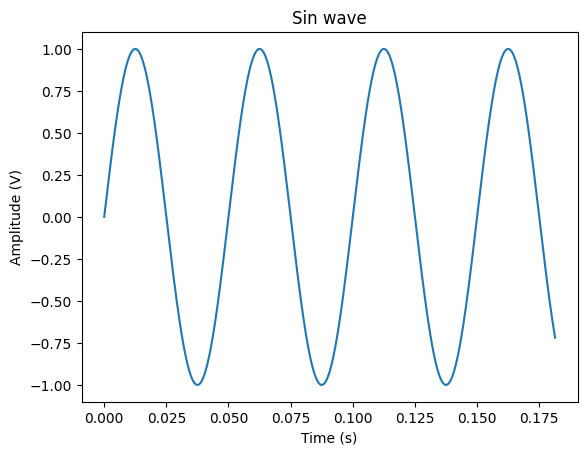

In [20]:
def get_max(s):
    max = float('-inf')
    for i in s:
        if i > max:
            max = i
    return max


def normalise(s):
    max = get_max(s)
    return s / max



t, samples = create_sine_wave(f, amplitude, fs, N)

plot_sin(t, samples)
plot_sin(t, normalise(samples))


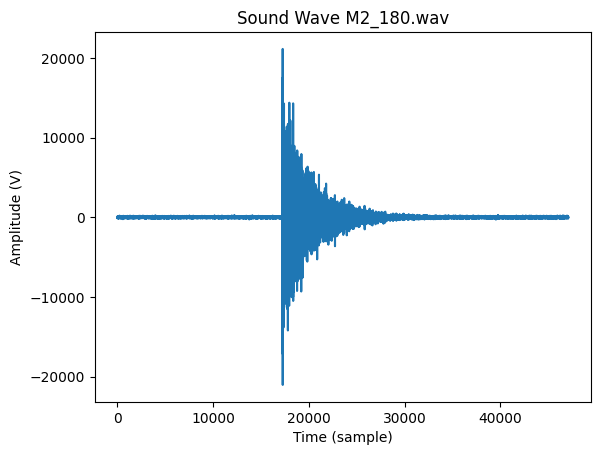

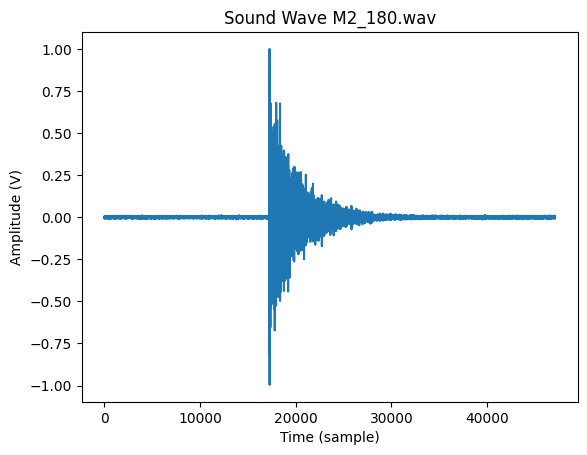

In [21]:

file_dir = "LocateClaps/"
file_name = "M2_180.wav"

_, data = read_wavefile(file_dir + file_name)

simple_plot(data, plt_title=f"Sound Wave {file_name}", x_label="Time (sample)", y_label="Amplitude (V)")
simple_plot(normalise(data), plt_title=f"Sound Wave {file_name}", x_label="Time (sample)", y_label="Amplitude (V)")


### 1.3.2 Downsampling

In [269]:
# Let's first take an example:
fs = 44.1 * 1000
N = 8000
f = 2500
amplitude = 8
plt.figure()
t, samples = create_sine_wave(f, amplitude, fs, N)
x = plt.specgram(normalise(samples), Fs=fs)
plt.figure()

# Using that example, let's do the same for one of the audio file :)
f, data = read_wavefile("LocateClaps/M1_0.wav")
x = plt.specgram(normalise(data), Fs=f)


We notice that the maximum value is *always* (FACT CHECK ME !!!) 8 kHz so by **Shannon's rule** : $$f_s \geq 2 \cdot f_{max} = 8000$$ so we will take $16000$ Hz. 
This is the lowest available frequency (RAPPORT: Expliquer pourquoi on doit pas forcèment prendre plus grand (avec la computational power))

#### 1.3.2

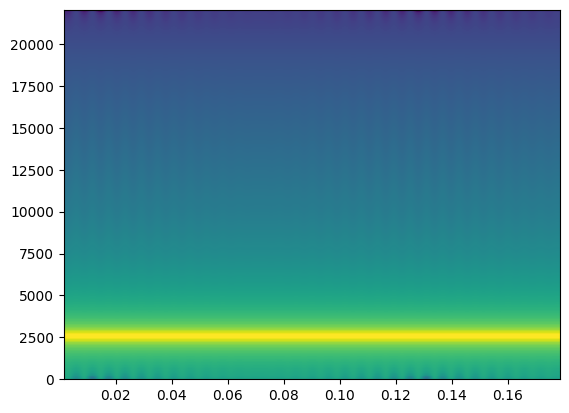

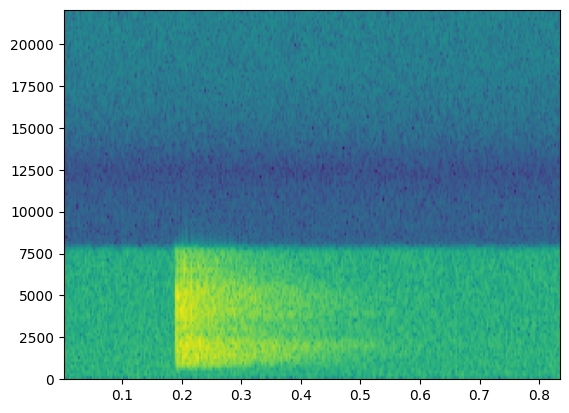

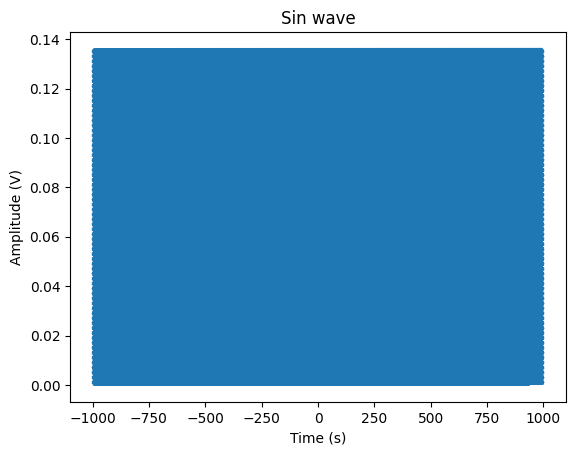

In [270]:
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    N, wn = signal.cheb1ord(wp, ws, gpass, gstop, fs=fs)
    return signal.cheby1(N, gpass, wn, "low", False, fs=fs) # lowpass because we need to filter out frequencies above a certain threshold

def create_filter_cauer(wp, ws, gpass, gstop, fs):
    N, wn = signal.ellipord(wp, ws, gpass, gstop, fs=fs)
    return signal.ellip(N, gpass, gstop, wn, 'low', False, fs=fs) # TODO: Explain this line (from previous report !!!!)



#w,h = signal.freqz(b_pb, a_pb, fs=400)
#plt.figure()
#
#plt.plot(w, np.abs(h))


t, sin_samples = create_sine_wave(8500, 1000, 44100, 6000)


#sin_samples = normalise(sin_samples)
plot_sin(sin_samples, t)
plt.figure()
freq_max = 8000
freq_min = 7500




(B, A) = create_filter_cheby(freq_min, freq_max,  1 ,  60 , 44100)


w_a, h_a = signal.freqz(B,A, fs= 44100)



plt.plot(w_a, 20 * np.log10(np.abs(h_a)))



Normalising does not change the value of A nor B